# Tarea Random Forest

Diego Lozoya Morales | 745345

# Paqueterías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [2]:
def calibracion(predicciones, y_test):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y_test
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=15, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure(figsize=(10, 5))
    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color=colors[1])
    plt.xlabel("Prediccion")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.grid()
    plt.legend()
    plt.show()

def interpretability(X, model, n_var):
    model_interpretability = pd.DataFrame({
          'Variable': X.keys(),
          'Importancia': model.feature_importances_
    })
    model_interpretability = model_interpretability.sort_values(by='Importancia', ascending=False).head(n_var)

    cmap = LinearSegmentedColormap.from_list("custom_coolwarm", [colors[1], colors[0]])
    custom_palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, len(model_interpretability))])

    plt.figure(figsize=(10, 5))
    sns.barplot(x="Importancia", y="Variable", data=model_interpretability, palette=custom_palette)
    for index, value in enumerate(model_interpretability["Importancia"]):
        plt.text(value + 0.002, index, f"{value:.4f}", va="center", fontsize=10)
    plt.xlabel('Importancia')
    plt.xlim(0, max(model_interpretability["Importancia"]) + 0.03)
    plt.ylabel('Variables')
    plt.title(f'{n_var} variables más importantes del Random Forest')
    plt.show()

# Data

In [3]:
data = pd.read_csv("Data/Boston.csv")
data.drop('Unnamed: 0', axis=1, inplace=True)
data = pd.get_dummies(data, columns=['rad'])
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,...,medv,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,...,24.0,True,False,False,False,False,False,False,False,False
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,...,21.6,False,True,False,False,False,False,False,False,False
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,...,34.7,False,True,False,False,False,False,False,False,False
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,...,33.4,False,False,True,False,False,False,False,False,False
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,...,36.2,False,False,True,False,False,False,False,False,False


## Variable dependiente

In [4]:
target = 'medv'
y = data[target]

# Cross Validation

In [5]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest

In [6]:
pipeline = Pipeline([
     ('rf', RandomForestRegressor(n_jobs=-1, random_state=42))
])

params = {
     'rf__n_estimators': [400, 500, 600],
     'rf__max_depth': [10, 12, 13, 15],
     'rf__max_features': ['log2', 'sqrt', 10, 12],
}
rf_grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, n_jobs=-1, scoring="r2")
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [10, 12, 13, 15],
                         'rf__max_features': ['log2', 'sqrt', 10, 12],
                         'rf__n_estimators': [400, 500, 600]},
             scoring='r2')

In [7]:
rf_grid.best_params_

{'rf__max_depth': 15, 'rf__max_features': 10, 'rf__n_estimators': 400}

## $R^2$ score

In [8]:
best_model = rf_grid.best_estimator_.named_steps["rf"]
predicciones_rf = best_model.predict(X_test)
r2 = r2_score(y_true=y_test, y_pred=predicciones_rf)
print(f"R2: {r2:.4f}")

R2: 0.8671


## Interpretabilidad

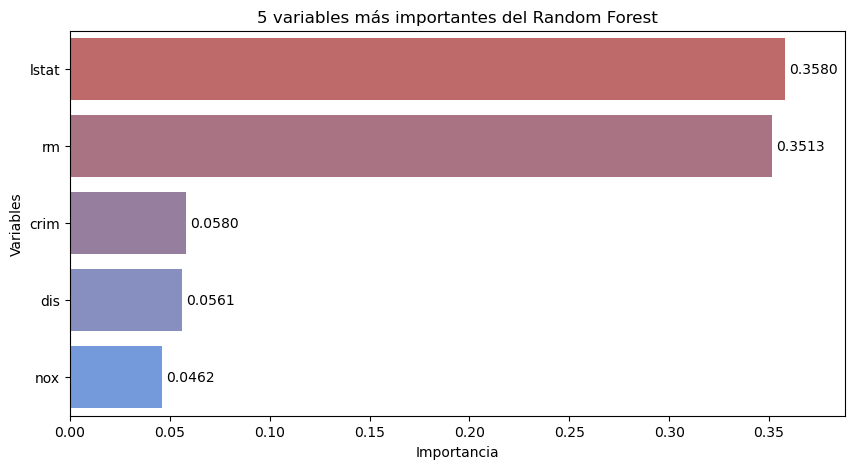

In [9]:
interpretability(X=X_train, model=best_model, n_var=5)

## Calibración

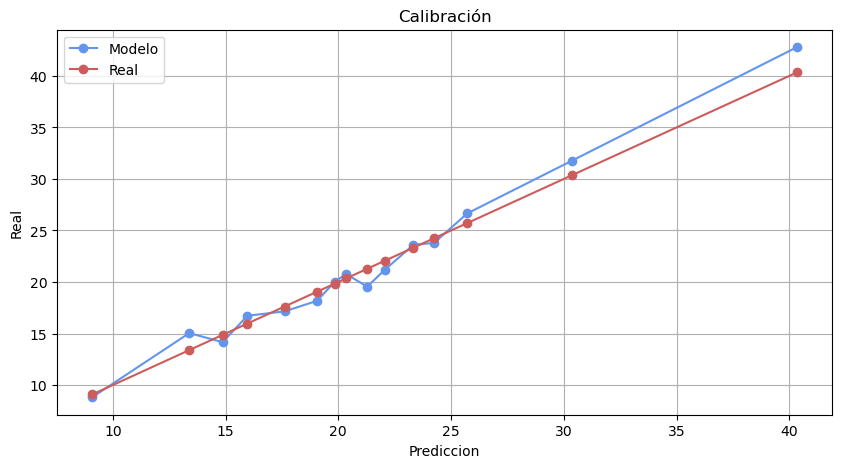

In [10]:
calibracion(predicciones_rf, y_test)

# Conclusiones

En el examen, el mejor modelo que se obtuvo, es una regresión lineal, con polinomio de grado 2, regularización Ridge y R2 de 0.8900, lo que significa que el 89% de la variación del precio mediano de las casas habitadas por sus dueños está explicada por el modelo.

Con un Random Forest con distintas combinaciones, el mejor resultado con base en el GridSearch, el modelo óptimo de RF es 400 árboles con 13 niveles de profundidad por árbol y tomando en cuenta máximo 10 variables por división del árbol. Con estas características se obtiene un R2 de 0.8671, lo que significa que el 86.71% de la variación del precio mediano de las casas habitadas por sus dueños está explicada por el modelo.

Se puede ver que el modelo lr es mejor que el rf, si se compara el R2 obtenido por modelo. Esto se puede deber a factores como la implementación de feature engineering. 